<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/tutors-service-users-analysis/tutors_service_users_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ аудитории сервиса подписки на репетиторов по ЕГЭ

## Описание кейса

- **Продукт**: подписка на репетиторов по ЕГЭ. Аудитория может приобрести пакет уроков по разным предметам. Учеба проходит на онлайн-платформе по программам обучения с уклоном в конкретную область: можно решать задачки, смотреть лекции и заниматься с репетитором.

## Описание данных

 В датасете есть поля:

- `program_name` – программа с уклоном в предметы:
    - `math&phys` – математика и физика,
    - `russ&lit` – русский и литература;
- `performance` – успеваемость пользователя (от 0 до 1, где 1 = 100%);
- `is_ege` – сдает ли пользователь ЕГЭ в этом году;
- `age` – возраст.

## Задачи

- сравнить различные группы аудитории по успеваемости:
    - входят ли пользователи разных групп `program_name` в один доверительный интервал по успеваемости (пересекаются ли доверительные интервалы между группами);
    - у какой группы `is_ege` разброс по средней успеваемости больше;
- предположить, какие выводы можно сделать на основе анализа.

## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import numpy as np
import pandas as pd

# исследовательский анализ данных
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

In [3]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/tutors-service-users-analysis'

In [5]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw1.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

## EDA

### Успеваемость в зависимости от программы

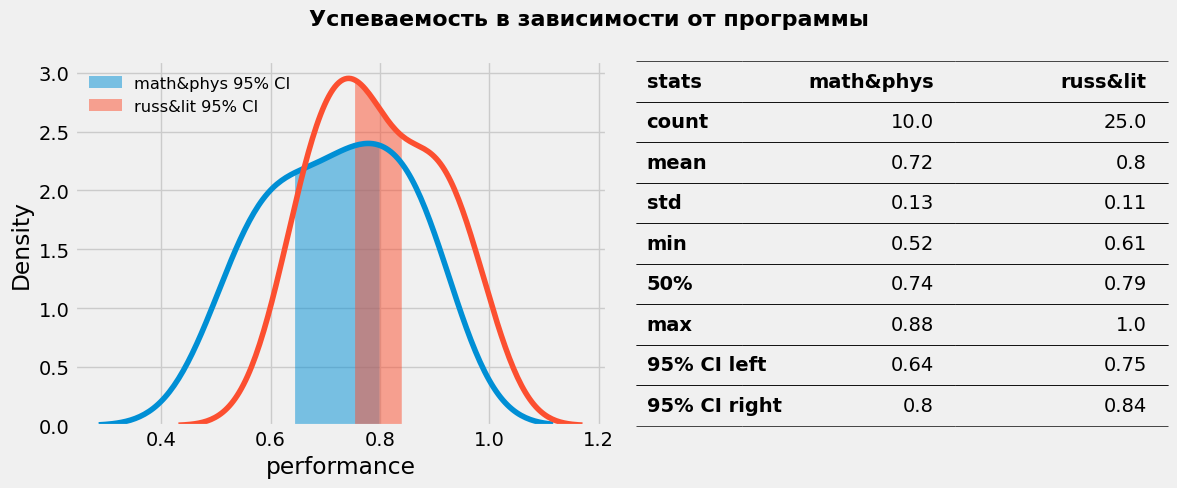

In [6]:
# вывод на экран графиков и статистик распределения значений успеваемости
# в зависимости от программы
fig, ax = plt.subplots(nrows   = 1,
                       ncols   = 2,
                       figsize = (12, 5))

fig.suptitle('Успеваемость в зависимости от программы',
             fontsize   = 16,
             fontweight = 'bold')

ax = ax.flatten()

cis_left = []
cis_right = []

for program, color in zip(data.program_name.unique(), ['#008fd5', '#fc4f30']):
    program_data = data[data.program_name == program]
    program_mean = np.mean(program_data.performance)
    program_std  = np.std(program_data.performance, ddof = 1)
    program_se   = program_std / np.sqrt(len(program_data))

    g = sns.kdeplot(data  = program_data,
                    x     = 'performance',
                    color = color,
                    ax    = ax[0])

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    ci_left = program_mean - program_se * 2
    ci_right = program_mean + program_se * 2

    cis_left.append(np.round(ci_left, 2))
    cis_right.append(np.round(ci_right, 2))

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci_left) & (x < ci_right),
                   alpha = 0.5, label = f'{program} 95% CI')

ax[0].legend(loc      = 'upper left',
             frameon  = False,
             fontsize = 'small')

feature_stats = data.groupby('program_name').performance.describe().T.round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats'},
                     inplace = True)

feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

the_table = ax[1].table(cellText  = feature_stats.values,
                        colLabels = feature_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        colWidths = [0.2, 0.4, 0.4],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

plt.tight_layout()
plt.show()

Мы видим, что:
- распределение значений успеваемости пользователей обеих выборок близко к нормальному;
- 95%-ый доверительный интервал значений успеваемости пользователей программы «математика и физика» значительно больше доверительного интервала аналогичных значений программы «русский и литература», что при сравнимых значениях стандартного отклонения (0.13 против 0.11) обусловлен меньшей выборкой (10 против 25);
- 95%-ые доверительные интервалы значений успеваемости пользователей программ «математика и физика» и «русский и литература» пересекаются.



### Успеваемость в зависимости от года сдачи ЕГЭ

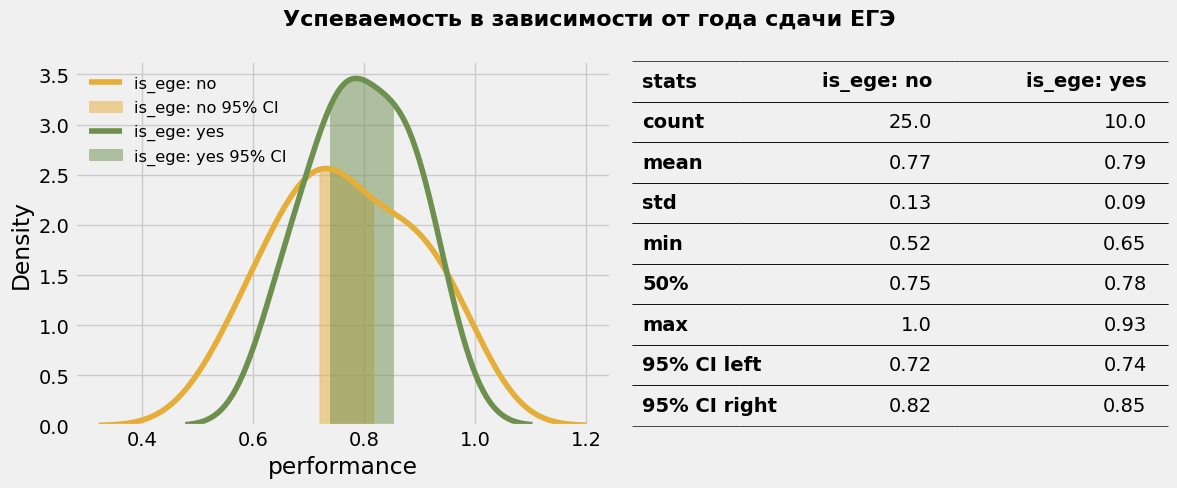

In [7]:
# вывод на экран графиков и статистик распределения значений успеваемости
# в зависимости от года сдачи ЕГЭ
fig, ax = plt.subplots(nrows   = 1,
                       ncols   = 2,
                       figsize = (12, 5))

fig.suptitle('Успеваемость в зависимости от года сдачи ЕГЭ',
             fontsize   = 16,
             fontweight = 'bold')

ax = ax.flatten()

cis_left = []
cis_right = []

for ege_status, color in zip(data.is_ege.unique(), ['#e5ae38', '#6d904f']):
    ege_data = data[data.is_ege == ege_status]
    ege_mean = np.mean(ege_data.performance)
    ege_std  = np.std(ege_data.performance, ddof = 1)
    ege_se   = ege_std / np.sqrt(len(ege_data))

    g = sns.kdeplot(data = ege_data,
                    x    = 'performance',
                    ax = ax[0],
                    color = color)

    x = g.lines[-1].get_xdata()
    y = g.lines[-1].get_ydata()

    ci_left = ege_mean - ege_se * 2
    ci_right = ege_mean + ege_se * 2

    cis_left.append(np.round(ci_left, 2))
    cis_right.append(np.round(ci_right, 2))

    g.fill_between(x,
                   y,
                   0,
                   where = (x > ci_left) & (x < ci_right),
                   alpha = 0.5,
                   color = color)

ax[0].legend(labels   = ['is_ege: no', 'is_ege: no 95% CI', 'is_ege: yes', 'is_ege: yes 95% CI'],
             loc      = 'upper left',
             frameon  = False,
             fontsize = 'small')

feature_stats = data.groupby('is_ege').performance.describe().T.round(2).reset_index()
feature_stats.rename(columns = {'index' : 'stats',
                                'no'    : 'is_ege: no',
                                'yes'   : 'is_ege: yes'},
                     inplace = True)

feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

the_table = ax[1].table(cellText  = feature_stats.values,
                        colLabels = feature_stats.columns,
                        bbox      = (0, 0, 1, 1),
                        colWidths = [0.2, 0.4, 0.4],
                        edges     = 'horizontal')

the_table.auto_set_font_size(False)
the_table.set_fontsize(14)

for k, cell in six.iteritems(the_table._cells):
    if k[1] == 0: cell.set_text_props(ha = 'left')
    else: cell.set_text_props(ha = 'right')
    if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

ax[1].axis('off')

plt.tight_layout()
plt.show()

Мы видим, что у группы пользователей, которая сдает ЕГЭ в этом году:
- меньше стандартное отклонение (0.09 против 0.13);
- меньше размах значений; но при этом
- больше 95%-й доверительный интервал, что при меньшем стандартном отклонении обусловлено меньшим размером выборки (10 против 25).

## Общие выводы

В ходе работы над кейсом мы проанализировали графики и статистики распределения значений успеваемости пользователей в зависимости от программы и года сдачи ЕГЭ.

По результатам анализа мы пришли к следующим выводам:

- успеваемость в зависимости от программы:
  - распределение значений успеваемости пользователей обеих выборок близко к нормальному;
  - 95%-ый доверительный интервал значений успеваемости пользователей программы «математика и физика» значительно больше доверительного интервала аналогичных значений программы «русский и литература», что при сравнимых значениях стандартного отклонения (0.13 против 0.11) обусловлен меньшей выборкой (10 против 25);
  - 95%-ые доверительные интервалы значений успеваемости пользователей программ «математика и физика» и «русский и литература» пересекаются;
- успеваемость в зависимости от года сдачи ЕГЭ: у группы пользователей, которая сдает ЕГЭ в этом году:
  - меньше стандартное отклонение (0.09 против 0.13);
  - меньше размах значений; но при этом больше 95%-й доверительный интервал, что при меньшем стандартном отклонении обусловлено меньшим размером выборки (10 против 25).